In [1]:
import numpy as np
import scipy.stats
from plotly import graph_objects as go
import ipywidgets as widgets
from pandas import *

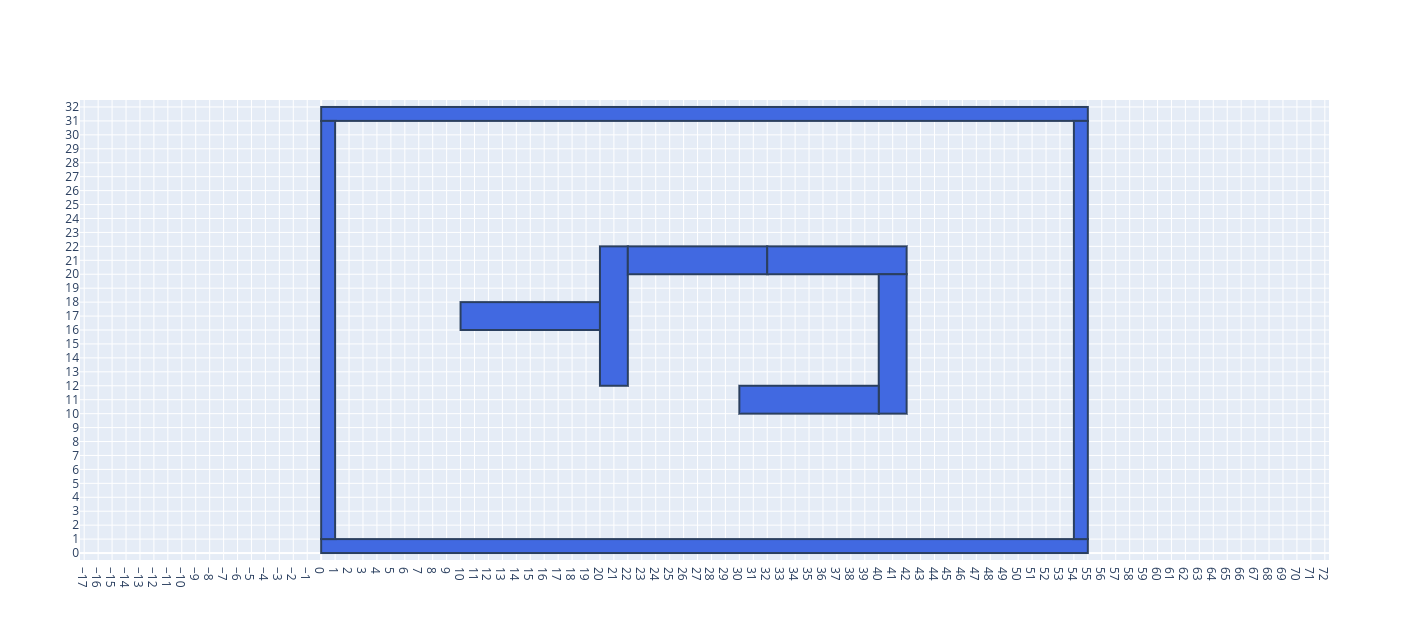

In [2]:
ROWS, COLUMNS = 32, 55

landmarks = np.array([
    [0, COLUMNS, 0, 1],
    [0, COLUMNS, ROWS-1, ROWS],
    [0, 1, 1, ROWS-1],
    [COLUMNS-1, COLUMNS, 1, ROWS-1],
    [10, 20, 16, 18],
    [20, 22, 12, 22],
    [22, 32, 20, 22],
    [32, 42, 20, 22],
    [40, 42, 10, 20],
    [30, 40, 10, 12],
])

WORLD = np.zeros((ROWS, COLUMNS))
for landmark in landmarks:
    x1, x2, y1, y2 = landmark
    WORLD[y1:y2+1, x1:x2+1] = 1

fig = go.Figure()
for landmark in landmarks:
    x0, x1, y0, y1 = landmark
    fig.add_shape(type='rect', fillcolor='RoyalBlue', x0=x0, x1=x1, y0=y0, y1=y1)
fig.update_xaxes(range=[-0.5, COLUMNS + 0.5], dtick=1)
fig.update_yaxes(range=[-0.5, ROWS + 0.5], dtick=1, scaleanchor='x')
fig.update_layout(height=20*ROWS, width=20*COLUMNS)
fig.show()

In [3]:
# class Robot:
#     def __init__(self, position, heading):
#         self.x, self.y = position
#         self.heading = heading
    
#     def move(self, steering_angle, steering_std=0.1, velocity=2, velocity_std=0.1, dt=1):
#         self.heading += np.random.normal(steering_angle, steering_std)
#         velocity = np.random.normal(velocity, velocity_std)
#         self.x += velocity * np.cos(self.heading) * dt
#         self.y += velocity * np.sin(self.heading) * dt
#         return [self.x, self.y, self.heading]

    # def sense(self, Q=0.3, max_sonar_depth=10):
    #     for d in range(1, max_sonar_depth):
    #         x = round(self.x + d * np.cos(self.heading))
    #         y = round(self.y + d * np.sin(self.heading))
    #         if not(0 <= x < COLUMNS and 0 <= y < ROWS) or WORLD[y, x] == 1:
    #             return d + np.random.normal(scale=Q)
    #     return max_sonar_depth

In [4]:
class ParticleFilter:
    def __init__(self, N):
        self.particles = self.initialize_particles(N, (1, COLUMNS-1), (1, ROWS-1), (0, 2*np.pi))
        self.weights = np.ones(N) / N
        self.N = N
    
    def initialize_particles(self, N, x_range, y_range, heading_range):
        particles = np.empty((N, 3))
        # particles[:, 0] = np.random.uniform(x_range[0], x_range[1]/2, size=N)
        particles[:, 0] = np.random.uniform(x_range[0], 15, size=N)
        # particles[:, 1] = np.random.uniform(y_range[0], y_range[1], size=N)
        particles[:, 1] = np.random.uniform(20, 30, size=N)
        particles[:, 2] = np.random.uniform(heading_range[0], heading_range[1], size=N)
        particles[:, 2] %= 2 * np.pi
        return particles
    
    def predict(self, steering_angle, steering_std, velocity, velocity_std, dt=1):
        self.particles[:, 2] += np.random.normal(steering_angle, steering_std, size=self.N)
        self.particles[:, 2] %= 2 * np.pi
        velocity = np.random.normal(velocity, velocity_std, size=self.N)
        self.particles[:, 0] += velocity * np.cos(self.particles[:, 2]) * dt
        self.particles[:, 1] += velocity * np.sin(self.particles[:, 2]) * dt
    
    def update(self, z, sensor_noise):
        distances = np.array([self.sense(particle) for particle in self.particles])
        self.weights *= scipy.stats.norm(distances, sensor_noise).pdf(z)
        self.weights += 1e-300  # avoid round-off to zero
        self.weights /= self.weights.sum()

    def sense(self, m, max_sonar_depth=80):
        for d in range(1, max_sonar_depth):
            x = round(m[0] + d * np.cos(m[2]))
            y = round(m[1] + d * np.sin(m[2]))
            if not(0 <= x < COLUMNS and 0 <= y < ROWS) or WORLD[y, x] == 1:
                return d
        return max_sonar_depth

    def resample(self):
        indexes = np.random.choice(np.arange(self.N), size=self.N, p=self.weights)
        self.particles = self.particles[indexes]
        self.weights.fill(1 / self.weights.shape[0])

In [5]:
data = read_csv("ToF_patka1.csv")
all_measurements = data['.range'][700:5700]
all_measurements = all_measurements.reset_index(drop=True)
def read_measurement():
    for element in range(1):
        first_element = all_measurements[element]
    return first_element
# all_measurements = all_measurements[1:]


In [6]:
# print(read_measurement()*50)
# all_measurements = all_measurements[1:]
# all_measurements = all_measurements.reset_index(drop=True)


In [7]:
def one_iteration(x=None):
    steering_angle = -steering_wheel.value / 180 * np.pi
    # robot_data = robot.move(steering_angle)
    # z = robot.sense()
    z = read_measurement()*50
    global all_measurements
    all_measurements = all_measurements[1:]
    all_measurements = all_measurements.reset_index(drop=True)
    
    
    pf.predict(steering_angle=steering_angle, steering_std=0.1, velocity=0.8, velocity_std=0.05)
    pf.update(z=z, sensor_noise=1)
    pf.resample()
    position_mean = np.average(pf.particles[:, :2], weights=pf.weights, axis=0)

    with fig.batch_update():
        fig.data[0].x, fig.data[0].y = pf.particles[:, 0], pf.particles[:, 1]
        fig.data[1].x, fig.data[1].y = [position_mean[0]], [position_mean[1]]
        # fig.data[2].x = [robot_data[0], robot_data[0] + z * np.cos(robot_data[2])]
        # fig.data[2].y = [robot_data[1], robot_data[1] + z * np.sin(robot_data[2])]
        fig.data[2].x, fig.data[2].y = pf.particles[:, 0], pf.particles[:, 1]

def create_ui():
    button = widgets.Button(description='Чекор')
    button.on_click(one_iteration)
    steering_wheel = widgets.IntSlider(value=0, min=-30, max=30, step=1, description='Волан:')
    play = widgets.Play(value=0, max=300, interval=1000, show_repeat=False)
    play.observe(one_iteration, 'value')
    return steering_wheel, button, play

def create_fig():
    fig = go.FigureWidget()
    for landmark in landmarks:
        x0, x1, y0, y1 = landmark
        fig.add_shape(type='rect', fillcolor='RoyalBlue', x0=x0, x1=x1, y0=y0, y1=y1)
    fig.add_scatter(name='Честици', mode='markers', opacity=0.3, visible='legendonly')
    fig.add_scatter(name='Филтер', mode='markers+lines', marker_size=12, marker_symbol = ['circle', 'x'])
    # fig.add_scatter(name='Робот', mode='markers+lines', marker_size=12, marker_symbol = ['circle', 'x'], line_dash='dash', visible='legendonly')
    xbins, ybins = dict(start=0, end=COLUMNS, size=0.2), dict(start=0, end=ROWS, size=0.2)
    fig.add_histogram2d(name='Хистограм', xbins=xbins, ybins=ybins, colorscale='YlOrBr', showscale=False, opacity=0.7)
    
    fig.update_xaxes(range=[-0.5, COLUMNS + 0.5], dtick=1)
    fig.update_yaxes(range=[-0.5, ROWS + 0.5], dtick=1, scaleanchor='x')
    fig.update_layout(width=20*COLUMNS, height=20*ROWS)
    return fig

In [8]:
# robot = Robot(position=(3, 28), heading=-1/1*np.pi/2)
pf = ParticleFilter(N=5000)

fig = create_fig()
steering_wheel, button, play = create_ui()
one_iteration()
widgets.VBox([widgets.HBox([play, steering_wheel, button]), fig])